# Fitting neutralization curves
Here we describe how to use the :mod:class:`neutcurve.CurveFits` class to fit a set of :mod:class:`hillcurve.HillCurve` neutralization curves to data.

## Importing the necessary packages
First, import the necessary Python modules.
In addition to the `neutcurve` package itself, we also use [pandas](https://pandas.pydata.org/) to hold the data:

In [1]:
import urllib.request

import pandas as pd

import neutcurve

## The neutralization data to fit
Now we get example data to fit.
We use as our example the neutralization of variants A/WSN/1933 (H1N1) influenza by the broadly neutralizing antibody FI6v3 from [Fig 6a of Doud et al (2018)](https://www.nature.com/articles/s41467-018-03665-3#Fig6).
These data in numerical form in a CSV file are [available here](https://github.com/jbloomlab/neutcurve/blob/master/docs/examples/data/Doud_et_al-FI6v3-neutdata.csv).
We start by downloading these data and reading them into a pandas DataFrame:

In [2]:
fi6v3_datafile = ('https://raw.githubusercontent.com/jbloomlab/neutcurve/'
                  'master/docs/examples/data/Doud_et_al-FI6v3-neutdata.csv')

with urllib.request.urlopen(fi6v3_datafile) as f:
    data = pd.read_csv(f)

Here are the first few lines of the data frame:

In [3]:
data.head()

,serum,virus,replicate,concentration,fraction infectivity
0,FI6v3,WT,1,0.000205,1.013734
1,FI6v3,WT,1,0.000478,0.942012
2,FI6v3,WT,1,0.001115,0.992850
3,FI6v3,WT,1,0.002602,0.966206
4,FI6v3,WT,1,0.006071,0.956703


And here are the last few lines:

In [4]:
data.tail()

,serum,virus,replicate,concentration,fraction infectivity
355,FI6v3,G47R-HA2,3,0.077122,0.063935
356,FI6v3,G47R-HA2,3,0.179952,-0.010571
357,FI6v3,G47R-HA2,3,0.419888,-0.021508
358,FI6v3,G47R-HA2,3,0.979739,-0.025734
359,FI6v3,G47R-HA2,3,2.286057,-0.027638


As can be seen above, the data are organized into five columns, all of which must be present.
These columns are:
  - *serum*: the name of the serum (or antibody). We can have several, but in this example there is just one.
    FI6v3 is actually an antibody, not a serum--but :mod:class:`neutcurve.CurveFits` is set up to refer to things as serum, so here we'll call it a "serum".
  - *virus*: the name of the virus being neutralized by the serum.
  - *replicate*: the replicate label for the measurement. Although you can have just one replicate, it's good experimental practice to have several.
    All the replicates for a given virus / serum combination must have been measured at the same concentrations.
  - *concentration*: the concentration of the serum.
  - *fraction infectivity*: the fraction infectivity of the virus at this concentration of the serum measured in this replicate.
  
Note that the data are in [tidy form](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html); you must make your data frame tidy before you can analyze it with :mod:class:`neutcurve.CurveFits`. 

## Fitting the curves
Once you have the tidy data frame, it's easy to pass it to :mod:class:`neutcurve.CurveFits`:

In [5]:
fits = neutcurve.CurveFits(data)

Note that :mod:class:`neutcurve.CurveFits` has the same `fixtop` and `fixbottom` arguments as described for a :mod:class:`hillcurve.HillCurve` in the previous section; it also has arguments that all you to name the columns in data something else (for instance, you can set `serum_col='antibody'` if your data frame lists antibodies instead of sera).

Now we can look at the different sera for which we have fit curves (in this case it's just FI6v3):

In [6]:
fits.sera

['FI6v3']

We can also look at the viruses measured against each serum.
Here we do this for "serum" FI6v3:

In [7]:
for serum in fits.sera:
    print(f"Viruses measured against {serum}:")
    print(fits.viruses[serum])

Viruses measured against FI6v3:
['WT', 'K(-8T)', 'P80D', 'V135T', 'K280A', 'K280S', 'K280T', 'N291S', 'M17L-HA2', 'G47R-HA2']


We can also look at the replicates for each serum and virus.
Here we just do that for serum *FI6v3* and virus *WT*.
See how in addition to the three replicates we have passed, there is also now an "average" replicate that is computed from the average of the other replicates:

In [8]:
fits.replicates[('FI6v3', 'WT')]

['1', '2', '3', 'average']

We can use the :mod:class:`curvefits.CurveFits.getHillCurve` method to get the fit for a particular
serum / virus / replicate combination.
For instance, here we do that for *serum* FI6v3 versus *virus* WT, *replicate* 1.
We then plot the curve and get the IC50:

The IC50 is 0.0169


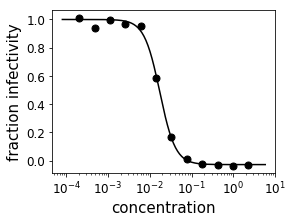

In [9]:
curve = fits.getHillCurve(serum='FI6v3', virus='WT', replicate='1')
print(f"The IC50 is {curve.ic50():.3g}")
fig, ax = curve.plot()

The :mod:class:`curvefits.CurveFits` also calculates the average and standard deviation of the measurements for each serum / virus, and fits them under a replicate name of "average".
So here is the fit to the average of the data for *serum* FI6v3 and *virus* WT.
Note how the plot now also shows error bars indicating the standard deviation:

The IC50 is 0.01619766


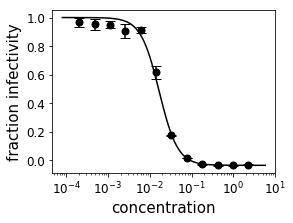

In [10]:
curve = fits.getHillCurve(serum='FI6v3', virus='WT', replicate='average')
print(f"The IC50 is {curve.ic50():.7g}")
fig, ax = curve.plot()